In [4]:
import h5py
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

# y_vocab preprocess

In [5]:
import _pickle
y_vocab = _pickle.load(open('./data/y_vocab.py3.cPickle', 'rb'))
y_vocab['43>109>1576>-1']
print(len(y_vocab))

token_to_cate = {}
for it in y_vocab.items():
     token_to_cate[it[1]] = it[0]

4215


# word preprocess

In [6]:
from myUtils.myUtils import *

In [9]:
helper = Helper()
seq_len=100
hash_size=4000

In [5]:
%%time
for i in range(1,10):
    helper.chunk_no = i
    helper.path = './data_org/train.chunk.0'+str(helper.chunk_no)
    print('------------%s-----------'%(helper.path))    
#     helper.makeDF(0, 10000, mode="train")
    helper.makeDF(0, 1000000, mode="train")    
    
    tmp_path_x = 'tmp/data_x_%d.csv' %(helper.chunk_no)
    tmp_path_y = 'tmp/data_y_%d.csv' %(helper.chunk_no)
    data_x = helper.df2data(tmp_path_x, seq_len=seq_len, hash_size=hash_size)
    data_y = helper.cate2token(tmp_path_y , y_vocab)

------------./data_org/train.chunk.01-----------


A Jupyter Widget

A Jupyter Widget


Wall time: 2min 27s


---
# data shuffle/sampling

In [38]:
"""%%time
# data io 는 판다스가 넘파이보다 훨씬 낫다
df2 = pd.read_csv('tmp/data_x_%d.csv'%(2), header=None)
data_x = df2.as_matrix()

np.savetxt('data/data_x_%d.csv'%(2), data_x, delimiter=',')

data_y = np.genfromtxt('tmp/data_y_%d.csv'%(1), delimiter=',', dtype=np.int16)"""

Wall time: 27.1 s


In [82]:
# split data set
test_ratio = 0.1
val_ratio = 0.001
train_ratio = 1-test_ratio-val_ratio

# data_x_val_all = []
# data_x_test_all = []
# data_y_val_all = []
# data_y_test_all = []

train_len = 0
val_len = 0
test_len = 0

for i,e in enumerate(range(1,10)):
    # read data x,y
    df_tmp = pd.read_csv('tmp/data_x_%d.csv'%(e), header=None)
    data_x = df_tmp.as_matrix()
    data_y = np.genfromtxt('tmp/data_y_%d.csv'%(e), delimiter=',', dtype=np.int16)
    
    assert len(data_x) == len(data_y)
    d_len = len(data_x)
    train_end = int(d_len*train_ratio)
    test_end = int(d_len*(train_ratio+test_ratio))

    X_train = data_x[:train_end]
    Y_train = data_y[:train_end]
    np.savetxt('data/data_x_%d.csv'%(e), X_train, delimiter=',')
    np.savetxt('data/data_y_%d.csv'%(e), Y_train, delimiter=',')

    X_test = data_x[train_end:test_end]
    Y_test = data_y[train_end:test_end]
    if i==0:
        data_x_test_all = X_test
        data_y_test_all = Y_test
    else:
        data_x_test_all = np.concatenate((data_x_test_all, X_test), axis=0)
        data_y_test_all = np.concatenate((data_y_test_all, Y_test), axis=0)

    X_val = data_x[test_end:]
    Y_val = data_y[test_end:]
    if i==0:
        data_x_val_all = X_val
        data_y_val_all = Y_val
    else:
        data_x_val_all = np.concatenate((data_x_val_all, X_val), axis=0)
        data_y_val_all = np.concatenate((data_y_val_all, Y_val), axis=0)
        
    train_len += len(X_train)
    test_len += len(X_test)
    val_len += len(X_val)
    print(train_len, test_len, val_len, '=====================================')
    
# write val, test set
np.savetxt('data/data_x_val.csv', data_x_val_all, delimiter=',')
np.savetxt('data/data_x_test.csv', data_x_test_all, delimiter=',')

np.savetxt('data/data_y_val.csv', data_y_val_all, delimiter=',')
np.savetxt('data/data_y_test.csv', data_y_test_all, delimiter=',')


899000 100000 1000 =====================================
1798000 200000 2000 =====================================
2697000 300000 3000 =====================================
3596000 400000 4000 =====================================
4495000 500000 5000 =====================================
5394000 600000 6000 =====================================
6293000 700000 7000 =====================================
7192000 800000 8000 =====================================
7313201 813482 8135 =====================================


# read val data

In [10]:
def set_train_data(no): # no 1-9
    assert no>=0 and no<=9
    df_tmp = pd.read_csv('data/data_x_%d.csv'%(no), header=None)
    X_train = df_tmp.as_matrix()
    Y_train = np.genfromtxt('data/data_y_%d.csv'%(no), delimiter=',', dtype=np.int16)
    Y_train = helper.onehot(Y_train)
    return (X_train, Y_train)

In [11]:
df_tmp = pd.read_csv('data/data_x_val.csv', header=None)
X_val = df_tmp.as_matrix()
Y_val = np.genfromtxt('data/data_y_val.csv', delimiter=',', dtype=np.int16)
Y_val = helper.onehot(Y_val)

In [12]:
print(X_val.shape, Y_val.shape)

(8135, 100) (8135, 4215)


In [13]:
# 피처 데이터, 레이블, 미니배치 갯수, random sampling
import random
random.seed(2018)
def getMiniBatch2(x, y, n):
    if len(x) != len(y):
        print('Feature and label num is not equal.')
        return
    rand_idx = random.sample(list(range(len(x))), n)
    x_ = [x[i] for i in rand_idx]
    y_ = [y[i] for i in rand_idx]
    return np.array(x_), np.array(y_)

In [14]:
%%time
getMiniBatch2(X_val, Y_val, 10)

(array([[3760.,  771., 3083., 2832., 3153., 2903., 1521., 3400., 3705.,
         3184., 1681., 3737., 1835., 3805., 2555., 3545., 2814., 1835.,
         3708., 1835., 2903.,  536., 2814., 1960., 3545., 1536., 1835.,
         3805., 3184.,  350., 3519., 1835.,  321.,  363., 1711., 2814.,
         1960., 1835.,  321., 2814., 1536., 1711., 3117., 3519., 3035.,
         3519.,   19., 3035.,   19., 1576.,  471., 1835., 2903., 1521.,
         3400., 3705., 3184., 1681., 1835., 3117., 1807.,  471., 3784.,
         1870., 3036., 1374., 2832., 1835.,  186.,  350., 2851.,   19.,
         3534., 1388.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.],
        [3760., 2853., 3837., 1835., 1576., 3951.,  349., 1835., 1437.,
         2913., 3737., 3760., 2375., 1870., 2375., 3666., 3737., 2003.,
          196.,  435., 3573., 3737., 3760., 251

# make model

In [15]:
# make DAG
tf.reset_default_graph()
tf.set_random_seed(2018)

# train Parameters
# seq_len = 35
output_dim = 4215 # 1번 트레이닝셋만

epoch = 80
batch_size = 1024
vocabulary_size = hash_size
embedding_size = 256


Y = tf.placeholder(tf.int16, [None, output_dim], name="label")
lr = tf.placeholder(tf.float32, [], name='learning_rate')
keep_prob = tf.placeholder(tf.float32, [], name="keep_prob")

#  embedding
X = tf.placeholder(tf.int32, [None, seq_len], name="word_tokens") 
word_embeddings = tf.get_variable("word_embeddings",
    [vocabulary_size, embedding_size], initializer=tf.contrib.layers.xavier_initializer())
embedded_word_ids = tf.nn.embedding_lookup(word_embeddings, X) # batch * seq * embeddding

#  dropout layer
def _sequence_dropout(step_inputs, keep_prob):
        # apply dropout to each input
        # input : a list of input tensor which shape is [None, input_dim]
        with tf.name_scope('sequence_dropout') as scope:
            step_outputs = []
            for t, _input in enumerate(step_inputs):
                step_outputs.append( tf.nn.dropout(_input, keep_prob) )
        return step_outputs

embedded_word_ids = tf.unstack(embedded_word_ids, axis=1)
step_inputs = _sequence_dropout(embedded_word_ids, keep_prob) # seq * batch * embedding


#  FCN layer
doc_mean = tf.reduce_mean(step_inputs, axis=0) # batch * embedding (mean)
# hint = tf.placeholder(tf.float32, [None, 609], name='hint') # previous category
# bf_lenear = tf.concat([doc_mean, hint], axis=1) # batch * (embediing + hint)
# bf_lenear = tf.nn.dropout(bf_lenear, keep_prob)

# Y_pred = tf.contrib.layers.fully_connected(bf_lenear, output_dim, activation_fn=tf.nn.relu)  # We use the last cell's output
Y_pred = tf.contrib.layers.fully_connected(doc_mean, output_dim, activation_fn=None)  # We use the last cell's output

# # image feature
# X = tf.placeholder(tf.float32, [None, len(data_x[0])], name="img_feat")
# X = tf.nn.dropout(X, keep_prob)
# Y_pred = tf.contrib.layers.fully_connected(X, output_dim,
#                                            activation_fn=tf.nn.relu, weights_initializer=tf.contrib.layers.xavier_initializer())  # We use the last cell's output

# optimize
cost =tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
    logits=Y_pred, labels=Y, name='cross_entropy'))
optimizer = tf.train.AdamOptimizer(lr)
train_step = optimizer.minimize(cost)

# prediction
predicted = tf.argmax(Y_pred, 1)
accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, tf.argmax(Y, 1)), dtype=tf.float32))

# saver
name_to_var_map = {var.op.name: var for var in tf.global_variables()}
saver = tf.train.Saver(name_to_var_map, name='my_saver')

# train/save

In [ ]:
%%time 

if 'sess' in globals(): sess.close()
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
sess.run(tf.global_variables_initializer())

x_range=[]
train_accuracies=[]
val_accuracies=[]
val_costs=[]
ckpt_path = './small_model/small'
lr_start = 0.002
# iter_per_epoch = int(len(Y_train)/batch_size)
iter_per_epoch = int(899000/batch_size)

print('total iter is %d * %d' %(epoch, iter_per_epoch))
for e in range(epoch):
# 데이터 청크 같으면 다시 로드 안하는 코드 넣기, 청크 순서도 고려해보기
    # epoch별 데이터 청크 로드
    chunk_no = int(e/2)%9+1
    X_train, Y_train = set_train_data(chunk_no)
    
    print('********** %d epoch started: lr-%g, chunk_no-%d **********'%(e, lr_start, chunk_no))
    for i in range(iter_per_epoch):
        X_, Y_ = getMiniBatch2(X_train, Y_train, batch_size) # 랜덤 미니배치 할당
        train_step.run(feed_dict={X:X_, Y:Y_, lr:lr_start, keep_prob:0.5})

    #   아래에 결과 프린트용
        if i % 100 == 0:   
            train_accuracy = accuracy.eval(feed_dict={X:X_, Y:Y_, lr:lr_start, keep_prob:0.5})
            val_accuracy, val_cost = sess.run([accuracy, cost], feed_dict={X:X_val, Y:Y_val, keep_prob:1})

            if lr_start>0.0001:
                lr_start = lr_start*0.998 # lr annealing
            
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)
            val_costs.append(val_cost)
            x_range.append(i+ iter_per_epoch*e)
            print('step %d: acc_tr %g, acc_val %g, cost_val %g' % (i, train_accuracy, val_accuracy, val_cost))
        
    saver.save(sess, ckpt_path, global_step=i+ iter_per_epoch*e)

total iter is 80 * 877
********** 0 epoch started: lr-0.002, chunk_no-1 **********
step 0: acc_tr 0.00683594, acc_val 0.00110633, cost_val 8.34419
step 100: acc_tr 0.0078125, acc_val 0.000860479, cost_val 8.83802
step 200: acc_tr 0.0146484, acc_val 0.000860479, cost_val 8.88062
step 300: acc_tr 0.0185547, acc_val 0.00221266, cost_val 8.91328
step 400: acc_tr 0.0712891, acc_val 0.0208974, cost_val 8.92219
step 500: acc_tr 0.0878906, acc_val 0.036386, cost_val 8.92413
step 600: acc_tr 0.144531, acc_val 0.0501537, cost_val 8.86716
step 700: acc_tr 0.185547, acc_val 0.0744929, cost_val 8.79976
step 800: acc_tr 0.244141, acc_val 0.0855562, cost_val 8.71556


# get accuracy for dev set

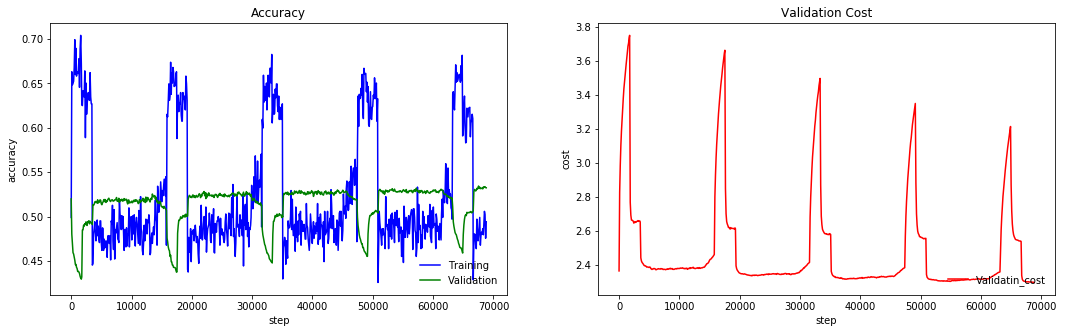

In [23]:
plt.figure(figsize=(18,5))
plt.subplot(121)
plt.plot(x_range, train_accuracies,'-b', label='Training')
plt.plot(x_range, val_accuracies,'-g', label='Validation')
plt.legend(loc='lower right', frameon=False)
# plt.ylim(ymax = 1.1, ymin = 0.7)
plt.ylabel('accuracy')
plt.xlabel('step')
plt.title('Accuracy')

plt.subplot(122)
plt.plot(x_range, val_costs,'-r', label='Validatin_cost')
plt.legend(loc='lower right', frameon=False)
# plt.ylim(ymax = 1.1, ymin = 0.7)
plt.ylabel('cost')
plt.xlabel('step')
plt.title('Validation Cost')
plt.show()

# test 

In [26]:
# restore model
if 'sess' in globals(): sess.close()
sess = tf.InteractiveSession()

ckpt_path = './small_model/small'
saver.restore(sess, ckpt_path+'-70159')

INFO:tensorflow:Restoring parameters from ./small_model/small-70159


In [16]:
%%time
df_tmp = pd.read_csv('data/data_x_test.csv', header=None)
X_test = df_tmp.as_matrix()
Y_test = np.genfromtxt('data/data_y_test.csv', delimiter=',', dtype=np.int16)
Y_test = helper.onehot(Y_test)

Wall time: 24.8 s


In [25]:
from math import ceil

# 여기서도 OOM 날수 있다
acc_tot = []
cost_tot = []
cate_predicted = []
chunk_size = 10000 # OOM 방지
iter_num = ceil(len(Y_test)/chunk_size)

for i in range(iter_num):
    test_accuracy, test_cost, tokens = \
        sess.run([accuracy, cost, predicted], feed_dict={X:X_test[chunk_size*i:chunk_size*(i+1)], Y:Y_test[chunk_size*i:chunk_size*(i+1)], keep_prob:1})
    acc_tot.append(test_accuracy)
    cost_tot.append(test_cost)
    
    for tok in tokens:
        cate_predicted.append(token_to_cate[tok].split('>'))
    print('Test Accuracy: %g \tTest cost: %g' %(test_accuracy, test_cost))
    
print('Total Accuracy:', np.array(acc_tot).mean(), '\tTotal Cost:', np.array(cost_tot).mean())

Test Accuracy: 0.574 	Test cost: 1.9491
Test Accuracy: 0.574 	Test cost: 1.90241
Test Accuracy: 0.5671 	Test cost: 1.94004
Test Accuracy: 0.5767 	Test cost: 1.89654
Test Accuracy: 0.5783 	Test cost: 1.91405
Test Accuracy: 0.5741 	Test cost: 1.93899
Test Accuracy: 0.5683 	Test cost: 1.94725
Test Accuracy: 0.5752 	Test cost: 1.90918
Test Accuracy: 0.5728 	Test cost: 1.9249
Test Accuracy: 0.5852 	Test cost: 1.85522
Test Accuracy: 0.5318 	Test cost: 2.30459
Test Accuracy: 0.5357 	Test cost: 2.28889
Test Accuracy: 0.5241 	Test cost: 2.39079
Test Accuracy: 0.5278 	Test cost: 2.3507
Test Accuracy: 0.5249 	Test cost: 2.33893
Test Accuracy: 0.5225 	Test cost: 2.36516
Test Accuracy: 0.5277 	Test cost: 2.33395
Test Accuracy: 0.5211 	Test cost: 2.37067
Test Accuracy: 0.5256 	Test cost: 2.36903
Test Accuracy: 0.539 	Test cost: 2.31537
Test Accuracy: 0.5215 	Test cost: 2.37602
Test Accuracy: 0.5306 	Test cost: 2.38405
Test Accuracy: 0.5179 	Test cost: 2.35077
Test Accuracy: 0.5245 	Test cost: 2.3279

In [26]:
# 분류 계층별 정확도 보기

# 나누기
cate_ans = []
for i in np.argmax(Y_test, axis=1):
    cate_ans.append(token_to_cate[i].split('>'))


cate_predicted = np.array(cate_predicted)
cate_ans = np.array(cate_ans)

# df_cate = pd.DataFrame(cate_predicted, columns=['bcateid', 'mcateid', 'scateid', 'dcateid'])
# 계산하기
cols=['bcateid', 'mcateid', 'scateid', 'dcateid']
aws_list = cate_ans.transpose([1,0]) == cate_predicted.transpose([1,0])

accs = []
for i, aws in enumerate(aws_list):
    _sum = np.sum(aws)
    acc = _sum/len(aws)
    accs.append(acc)
    print('%s: %g \t %d/%d' %(cols[i], acc, _sum, len(aws)))
    
print('final score:', (accs[0]+accs[1]*1.2+accs[2]*1.3+accs[3]*1.4)/4) 
print('아직 결측치 보정은 안함')

bcateid: 0.750246 	 610312/813482
mcateid: 0.686605 	 558541/813482
scateid: 0.602265 	 489932/813482
dcateid: 0.948475 	 771567/813482
final score: 0.9212455223348518
아직 결측치 보정은 안함


In [62]:
# 결측치 보정
sid = Counter(df['scateid'])
sratio = (len(df['scateid']) - sid.get(-1))/len(df['scateid'])
np.array(acc_tot).mean()/sratio

0.7073726530058878

---
0.002 --> 0.86 어닐링 없이
 - 최고 정확도

### 할일
- 텐서보드 붙이기
- ~~모델 저장하기~~
- ~~이니셜라이저 사용~~
- 4가지 레이블 맞추기
    - 점수 제작 코드
- ~~대분류당 중분류 중복 안되는지~~
    - 패턴먼저 파악하기
    - 중복 안되면 강제로 CRF적용가능
    - 중복 안됨
- 모듈화
    - myUtils.py 에 정리하기
    
---
데이터가 1,2와 3이 많이 다르네
 - 훈련 지속할 파이프라인 구축이 우선
 - 배치놈 반드시 필요할듯
    